In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        
#                         for i in range(len(label)):
#                             if label[i] == 'NA':
#                                 label[i] = 'O'
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/output_cl/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

print len(data_list)

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words)
print n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print n_tags

[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'CL:0000210'), ('Expressing', 'O'), ('Both', 'O'), ('Rod', 'CL:0000604'), ('and', 'O'), ('Cone', 'CL:0000573'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O'), ('.', 'O')]
3042
9088
68


In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

# print word2idx['Hybrid']
# print tag2idx["O"]

In [7]:
print tag2idx

{'O': 0, 'CL:0000775': 1, 'CL:0000558': 2, 'CL:0000100': 3, 'CL:0000127': 4, 'CL:0000771': 5, 'CL:0000103': 6, 'CL:0000129': 7, 'CL:0000556': 8, 'CL:0000670': 9, 'CL:0000573': 10, 'CL:0000738': 11, 'CL:0000636': 12, 'CL:0000120': 13, 'CL:0000300': 14, 'CL:0000576': 15, 'CL:0000540': 48, 'CL:0000365': 17, 'CL:0000187': 18, 'CL:0000836': 20, 'CL:0000209': 22, 'CL:0000125': 25, 'CL:0000232': 65, 'CL:0000031': 26, 'CL:0000182': 27, 'CL:0000018': 28, 'CL:0000019': 29, 'CL:0000017': 30, 'CL:0000609': 32, 'CL:0000763': 33, 'CL:0000764': 34, 'CL:0000057': 35, 'CL:0000748': 36, 'CL:0000136': 37, 'CL:0000210': 38, 'CL:0000138': 39, 'CL:0000601': 40, 'CL:0000745': 41, 'CL:0000333': 31, 'CL:0000740': 19, 'CL:0000604': 44, 'CL:0000589': 45, 'CL:0000059': 46, 'CL:0000561': 47, 'CL:0000092': 16, 'CL:0000216': 24, 'CL:0000542': 50, 'CL:0000312': 51, 'CL:0000353': 52, 'CL:0000584': 23, 'CL:0000586': 54, 'CL:0000099': 55, 'CL:0000214': 42, 'CL:0000135': 53, 'CL:0000234': 56, 'CL:0000767': 57, 'CL:000084

In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

94


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [13]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [14]:
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [15]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=100,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(GRU(units=100, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(GRU(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [17]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [18]:
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 100)  9600        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 100)      909000      input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [19]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=15, validation_data=([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te).reshape(len(y_te), max_len, 1)),
                    verbose=1)

Train on 2129 samples, validate on 913 samples
Epoch 1/15
2129/2129 [==============================] - 23s 11ms/step - loss: 0.3476 - acc: 0.9304 - val_loss: 0.0965 - val_acc: 0.9479
Epoch 2/15
2129/2129 [==============================] - 22s 10ms/step - loss: 0.0456 - acc: 0.9855 - val_loss: 0.0759 - val_acc: 0.9931
Epoch 3/15
2129/2129 [==============================] - 22s 10ms/step - loss: 0.0229 - acc: 0.9954 - val_loss: 0.0277 - val_acc: 0.9950
Epoch 4/15
2129/2129 [==============================] - 22s 10ms/step - loss: 0.0163 - acc: 0.9964 - val_loss: 0.0259 - val_acc: 0.9951
Epoch 5/15
2129/2129 [==============================] - 21s 10ms/step - loss: 0.0143 - acc: 0.9961 - val_loss: 0.0251 - val_acc: 0.9952
Epoch 6/15
2129/2129 [==============================] - 21s 10ms/step - loss: 0.0122 - acc: 0.9969 - val_loss: 0.0249 - val_acc: 0.9952
Epoch 7/15
2129/2129 [==============================] - 22s 10ms/step - loss: 0.0096 - acc: 0.9974 - val_loss: 0.0238 - val_acc: 0.9953
E

In [20]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/CL_merged_CHAR_GRU_Based.tsv', sep='\t')

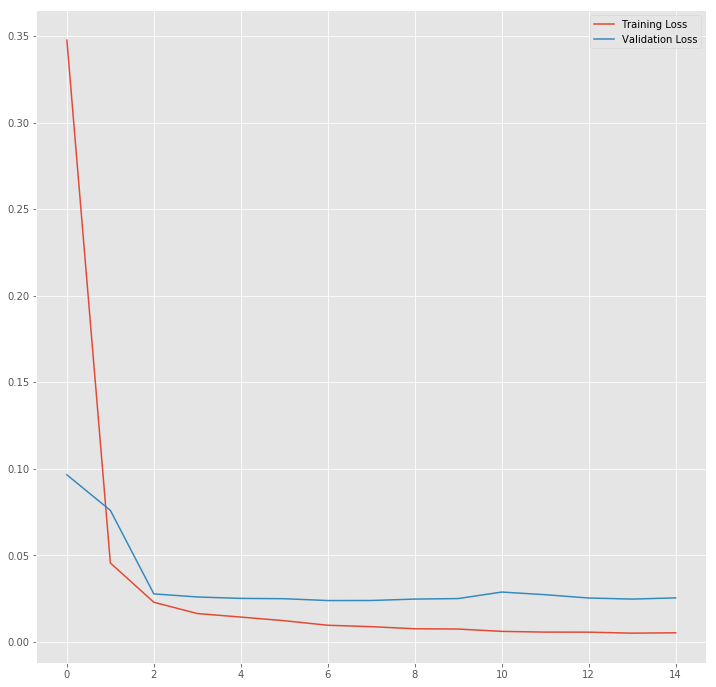

In [21]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

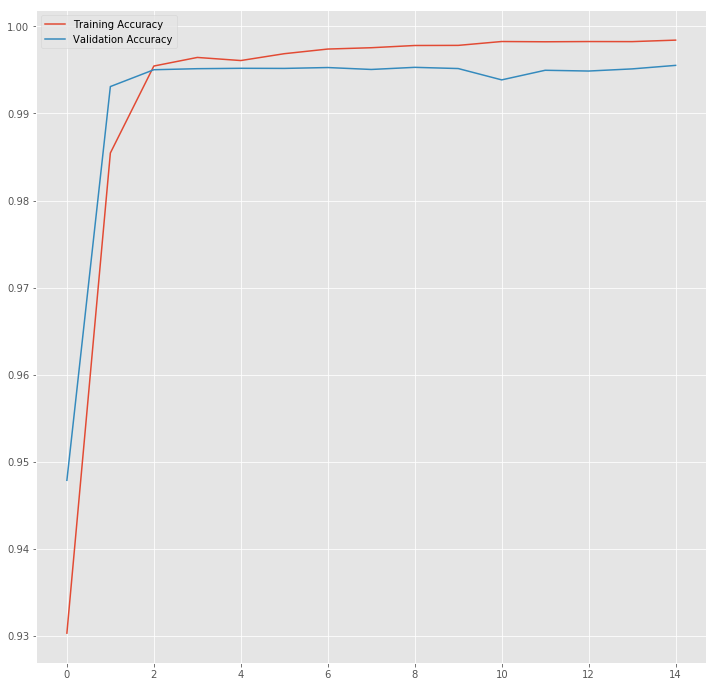

In [22]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = y_te[i]
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

print word[2]
print predicted_val[2]
print true[2]

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]


print wd[2]
print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[ 132 2275 7878 7251 4390 7878 6950 5279 5311  918 4865 1742 2461  335
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[ 0  0  0  0 67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
[ 0  0  0  0 67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
['A', 'total', 'of', '50', 'cells', 'of', 'each', 'genotype', 'were', 'quantitated', 'in', 'this', 'manner', '.', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], y_te[i], pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))

# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
onethird       : O     O
bluestained    : CL:0000000 CL:0000000
DM             : O     O
MMTV           : O     O
amplify        : O     O
20             : O     O
lamina         : O     O
postpartum     : O     O
if             : O     O
07             : O     O
Ia             : O     O
magnified      : O     O
gonocytes      : O     O
decline        : O     O
TFIIH          : O     O
Wnts           : O     O
husbandry      : O     O
fast           : O     O
VectashieldDAPI: O     O
bins           : O     O
marrow         : O     O
VectashieldDAPI: O     O
Protein        : O     O
Wnts           : O     O
initial        : O     O
edge           : O     O
ameliorate     : O     O
Most           : O     O
much           : O     O


In [25]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [26]:
df = df[df['Word'] != 'O']

In [27]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]
report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print "\n"
print report



             precision    recall  f1-score   support

 CL:0000000       0.99      1.00      1.00       834
 CL:0000017       1.00      0.82      0.90        17
 CL:0000018       1.00      0.50      0.67         2
 CL:0000019       1.00      0.33      0.50         3
 CL:0000020       1.00      1.00      1.00         1
 CL:0000023       1.00      0.80      0.89         5
 CL:0000025       1.00      1.00      1.00         3
 CL:0000057       0.78      0.88      0.82         8
 CL:0000062       1.00      1.00      1.00         8
 CL:0000092       1.00      0.80      0.89         5
 CL:0000099       1.00      1.00      1.00         1
 CL:0000100       0.00      0.00      0.00         1
 CL:0000103       0.25      0.50      0.33         2
 CL:0000120       0.00      0.00      0.00         1
 CL:0000125       0.25      1.00      0.40         2
 CL:0000127       0.89      1.00      0.94         8
 CL:0000129       1.00      1.00      1.00         3
 CL:0000135       1.00      1.00      1.00 

In [28]:
df.to_csv('../data/results/CL_CHAR_GRU_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/CL_CHAR_GRU_Based.tsv ../data/validation_data/CL_AllSubsumers.tsv

Mean semantic similarity:  0.925
